# CUDA Programming

**Reference**

    CUDA programming in Julia
    https://cuda.juliagpu.org/stable/
    

## Installation


    Nowadays, most GPU packages are easy to install: Just do a `Pkg.add("CUDA")` and everything should work out-of-the-box. 
    The only thing you need is a functional NVIDIA driver, but you don't need to install the CUDA toolkit.
  

## Check CUDA installation

In [ ]:
using CUDA

In [ ]:
CUDA.versioninfo()

# A simple example on the CPU

https://cuda.juliagpu.org/stable/tutorials/introduction/

We'll consider the following demo, a simple calculation on the CPU.

In [ ]:
N = 2^20
x = fill(1.0f0, N)  # a vector filled with 1.0 (Float32)
y = fill(2.0f0, N)  # a vector filled with 2.0

y .+= x # increment each element of y with the corresponding element of x

In [ ]:
using Test
@test all(y .== 3.0f0)

From the Test Passed line we know everything is in order. We used Float32 numbers in preparation for the switch to GPU computations: GPUs are faster (sometimes, much faster) when working with Float32 than with Float64.

A distinguishing feature of this calculation is that every element of y is being updated using the same operation. This suggests that we might be able to parallelize this.

## Parallelization on the CPU

First let's do the parallelization on the CPU. We'll create a "kernel function" (the computational core of the algorithm) in two implementations, first a sequential version:

In [ ]:
function sequential_add!(y, x)
    for i in eachindex(y, x)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y, 2)
sequential_add!(y, x)
@test all(y .== 3.0f0)

And now a parallel implementation:

In [ ]:
using Base.Threads

In [ ]:
nthreads()

In [ ]:
function parallel_add!(y, x)
    Threads.@threads for i in eachindex(y, x)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y, 2)
parallel_add!(y, x)
@test all(y .== 3.0f0)

In [ ]:
using BenchmarkTools
@btime sequential_add!($y, $x)

In [ ]:
@btime parallel_add!($y, $x)

You can see there's a performance benefit to parallelization, though not by a factor of 6 (`nthreads()`) due to the overhead for starting threads. With larger arrays, the overhead would be "diluted" by a larger amount of "real work"; these would demonstrate scaling that is closer to linear in the number of cores. Conversely, with small arrays, the parallel version might be slower than the serial version.

# Parallelization on GPU


## using GPU (`CuArray`) without writing kernels

Julia, as many other languages, allows to perform certain operations on GPU as you would do on CPU. Thanks to Julia's multiple dispatch, this is almost invisible and it is sufficient to convert the `Array` to `CuArray` to notify the system that array is in GPU's memory.


We'll first demonstrate GPU computations at a high level using the `CuArray` type, without explicitly writing a kernel function:

In [ ]:
using CUDA

In [ ]:
x_d = CUDA.fill(1.0f0, N)  # a vector stored on the GPU filled with 1.0 (Float32)
y_d = CUDA.fill(2.0f0, N)  # a vector stored on the GPU filled with 2.0

Here the d means "device," in contrast with "host". Now let's do the increment:

In [ ]:
y_d .+= x_d
@test all(Array(y_d) .== 3.0f0)

The statement `Array(y_d)` moves the data in y_d back to the host for testing. If we want to benchmark this, let's put it in a function:

In [ ]:
function add_broadcast!(y, x)
    CUDA.@sync y .+= x
    return
end

In [ ]:
@btime add_broadcast!($y_d, $x_d)

The most interesting part of this is the call to `CUDA.@sync`. The CPU can assign jobs to the GPU and then go do other stuff (such as assigning more jobs to the GPU) while the GPU completes its tasks. Wrapping the execution in a `CUDA.@sync` block will make the CPU block until the queued GPU tasks are done, similar to how `Base.@sync` waits for distributed CPU tasks. Without such synchronization, you'd be measuring the time takes to launch the computation, not the time to perform the computation. But most of the time you don't need to synchronize explicitly: many operations, like copying memory from the GPU to the CPU, implicitly synchronize execution.

For this particular computer and GPU, you can see the GPU computation was significantly faster than the single-threaded CPU computation, and that the use of multiple CPU threads makes the CPU implementation competitive. Depending on your hardware you may get different results.

In [ ]:
function gpu_add1!(y, x)
    for i = 1:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y_d, 2)
@cuda gpu_add1!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

Aside from using the `CuArrays` x_d and y_d, the only GPU-specific part of this is the kernel launch via `@cuda`. The first time you issue this @cuda statement, it will compile the kernel (gpu_add1!) for execution on the GPU. Once compiled, future invocations are fast. You can see what `@cuda` expands to using `?@cuda` from the Julia prompt.

Let's benchmark this:

In [ ]:
function bench_gpu1!(y, x)
    CUDA.@sync begin
        @cuda gpu_add1!(y, x)
    end
end

In [ ]:
@btime bench_gpu1!($y_d, $x_d)

That's a lot slower than the version above based on broadcasting. What happened?

# Writing  own CUDA kernels

Before diving into details, let's recall some basic from the above HW section:

- In CUDA programming model, you usually write kernels, which represent body of a for loop.

- N iterations of the loop is divided into blocks and each block into warps. Single warp consists of 32 threads and these threads are executed simultaneously. All threads in the block are executed in the same SM, having access to the shared memory.


- Each thread executes the kernel for one iteration of the for loop. This means that inside the kernel, you need to determine the index of the iteration. Therefore you will see in kernels statements like

 i = threadIdx().x + (blockIdx().x - 1) * blockDim().x

where threadIdx().x is the index of the thread within the block, blockDim().x is the total number of threads in the block, and blockIdx().x is the index of the block within the grid. x property suggest that you can partition the execution along three-dimensional cube (three nested for loops), which might be sometimes useful.

The most trivial example of a kernel is addition as:

In [ ]:
function vadd!(c, a, b, n)
    i = threadIdx().x + (blockIdx().x - 1) * blockDim().x
    if i <= n
        c[i] = a[i] + b[i]
    end
    return # Make sure your kernel function ends in `return`, `return nothing` or `nothing`.
end

In [ ]:
M = 100_000

# host vectors
h_a = fill(1f0, M)
h_b = fill(2f0, M)
h_c = h_a + h_b

# device vectors
d_a = CuArray(h_a)
d_b = CuArray(h_b)
d_c = CUDA.fill(0f0, M); # d_c = similar(d_a)

In [ ]:
@cuda threads=512 blocks=cld(length(d_a), 512) vadd!(d_c, d_a, d_b, length(d_a))

In [ ]:
h_c ≈ Vector(d_c)

In [ ]:
function gpu_add2!(y, x)
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y_d, 2)
@cuda threads=256 gpu_add2!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

Note the threads=256 here, which divides the work among 256 threads numbered in a linear pattern. (For a two-dimensional array, we might have used threads=(16, 16) and then both x and y would be relevant.)

Now let's try benchmarking it:

In [ ]:
function bench_gpu2!(y, x)
    CUDA.@sync begin
        @cuda threads=256 gpu_add2!(y, x)
    end
end

In [ ]:
@btime bench_gpu2!($y_d, $x_d)

Much better!

But obviously we still have a ways to go to match the initial broadcasting result. To do even better, we need to parallelize more. GPUs have a limited number of threads they can run on a single streaming multiprocessor (SM), but they also have multiple SMs. To take advantage of them all, we need to run a kernel with multiple blocks. We'll divide up the work like this:

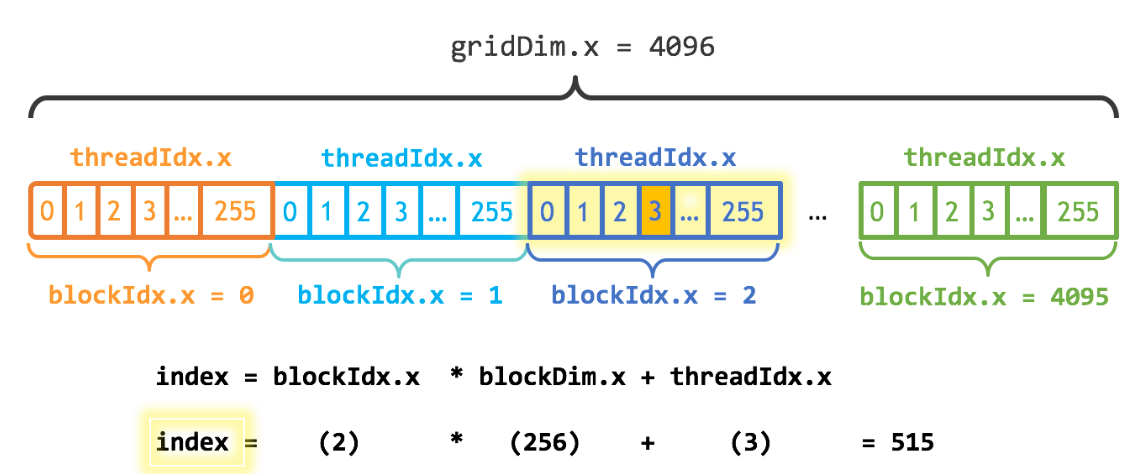

In Julia, threads and blocks begin numbering with 1 instead of 0. In this diagram, the 4096 blocks of 256 threads (making 1048576 = 2^20 threads) ensures that each thread increments just a single entry; however, to ensure that arrays of arbitrary size can be handled, let's still use a loop:



In [ ]:
function gpu_add3!(y, x)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    
    @inbounds y[index] += x[index]

"""
    stride = gridDim().x * blockDim().x
    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
    end
"""   
    return
end

numThreads = 256
numblocks = cld(N, numThreads) # ceil(Int, N/256)

fill!(y_d, 2)
@cuda threads=numThreads blocks=numblocks gpu_add3!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

The benchmark:

In [ ]:
function bench_gpu3!(y, x)
    numblocks = cld(N,256) # ceil(Int, length(y)/256)
    CUDA.@sync begin
        @cuda threads=256 blocks=numblocks gpu_add3!(y, x)
    end
end

In [ ]:
@btime bench_gpu3!($y_d, $x_d)

Finally, we've achieved the similar performance to what we got with the broadcasted version. Let's run `nvprof` again to confirm this launch configuration:

In the previous example, the number of threads was hard-coded to 256. This is not ideal, as using more threads generally improves performance, but the maximum number of allowed threads to launch depends on your GPU as well as on the kernel. To automatically select an appropriate number of threads, it is recommended to use the launch configuration API. This API takes a compiled (but not launched) kernel, returns a tuple with an upper bound on the number of threads, and the minimum number of blocks that are required to fully saturate the GPU:

In [ ]:
kernel = @cuda launch=false gpu_add3!(y_d, x_d)
config = launch_configuration(kernel.fun)
threads = min(N, config.threads)
blocks = cld(N, threads)

In [ ]:
threads, blocks

The compiled kernel is callable, and we can pass the computed launch configuration as keyword arguments:

In [ ]:
fill!(y_d, 2)
kernel(y_d, x_d; threads, blocks)
@test all(Array(y_d) .== 3.0f0)

Now let's benchmark this:

In [ ]:
function bench_gpu4!(y, x)
    kernel = @cuda launch=false gpu_add3!(y, x)
    config = launch_configuration(kernel.fun)
    threads = min(length(y), config.threads)
    blocks = cld(length(y), threads)

    CUDA.@sync begin
        kernel(y, x; threads, blocks)
    end
end

In [ ]:
@btime bench_gpu4!($y_d, $x_d)

A comparable performance; slightly slower due to the use of the occupancy API, but that will not matter with more complex kernels.

# Printing

When debugging, it's not uncommon to want to print some values. This is achieved with @cuprint:

In [ ]:
function gpu_add2_print!(y, x)
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
    @cuprintln("thread $index, block $stride")
    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

@cuda threads=16 gpu_add2_print!(y_d, x_d)
synchronize()

Note that the printed output is only generated when synchronizing the entire GPU with synchronize(). This is similar to CUDA.@sync, and is the counterpart of cudaDeviceSynchronize in CUDA C++.

# Error-handling

Note that the kernels above used @inbounds, but did not check whether y and x have the same length. If your kernel does not respect these bounds, you will run into nasty errors:

ERROR: CUDA error: an illegal memory access was encountered (code #700, ERROR_ILLEGAL_ADDRESS)
Stacktrace:
 [1] ...

If you remove the @inbounds annotation, instead you get

ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.

As the error message mentions, a higher level of debug information will result in a more detailed report. Let's run the same code with with -g2:

ERROR: a exception was thrown during kernel execution.
Stacktrace:
 1. throw_boundserror at abstractarray.jl:484
 2. checkbounds at abstractarray.jl:449
 3. setindex! at /home/tbesard/Julia/CUDA/src/device/array.jl:79
 4. some_kernel at /tmp/tmpIMYANH:6

# More examples of using GPU (`CuArray`) without writing kernels

## Matrix Multiplication on CPU and GPU

In [ ]:
# CPU (host) array
x = randn(Float32, 1000, 1000)
y = randn(Float32, 1000, 1000)
z = x * y 

# GPU (device) CuArray
cx = CuArray(x)
cy = CuArray(y)
cz = cx * cy

x * y ≈ Matrix(cx * cy) # The binary operator ≈ is equivalent to isapprox

In [ ]:
z == Matrix(cz)

## Timing

In [ ]:
@btime x * y;

In [ ]:
@btime cx * cy;

In [ ]:
@btime CUDA.@sync cx * cy;

In [ ]:
@btime Matrix(CuArray(x) * CuArray(y));

In [ ]:
x * y ≈ Matrix(CuArray(x) * CuArray(y))

## CUDA.jl map and reduce functions

`CUDA.jl` implements generic map and reduce (albeit performant reduce operation is very difficult), which allows you to pass your function greatly extending the functionality.

In [ ]:
sin.(cx).^2 .+ cos.(cx).^2
map(x -> sin(x)^2 + cos(x)^2, cx)
reduce(max, cx)
reduce(max, cx, dims = 1)

Notice that in case, the function in map and in broadcasting is essentially a custom kernel. As such, the code within has to still obey (not precisely specified) rules on what can be executed as kernel. Also needless to say, that the generic map over CuArray will try to find good launch configuration (number of threads and number of blocks), which might not be an ideal for your application.

## ## Computing Julia Set

Let's now try to use CUDA on computation of Julia set, which should benefit a lot from CUDA's paralelization, as we can dispatch each pixel to each thread –- something GPUs were originally designed for.

In [ ]:
function juliaset_pixel(i, j, n)
    c = ComplexF32(-0.79f0, 0.15f0);
    z = ComplexF32(-2f0 + (j-1)*4f0/(n-1), -2f0 + (i-1)*4f0/(n-1))
    for k in UnitRange{Int32}(0:255)
        abs2(z)> 4.0 && return(k%UInt8)
        z = z*z + c
    end
    return(255%UInt8)
end

In [ ]:
n = Int32(1000);
is = collect(Int32, 1:n)';
js = collect(Int32, 1:n);
img = @btime juliaset_pixel.(is, js, n);

In [ ]:
typeof(img), size(img)

In [ ]:
cis = CuArray(is);
cjs = CuArray(js);
img = juliaset_pixel.(cis, cjs, n);
@btime CUDA.@sync juliaset_pixel.(cis, cjs, n);

We see that CPU version takes around 50ms with the GPU version takes about 64μs, which is three order of magnited faster. Notice that we have obtained this speedup almost for free without writing anything that would be GPU specific. Our juliset_pixel is the same function working the same on CPU and on GPU. If we take into the account moving the memory:

In [ ]:
@btime Matrix(juliaset_pixel.(CuArray(is), CuArray(js), n));